# Packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
from diplom.data import CNNDataset
from tqdm import tqdm
import plotly.graph_objs as go
from diplom.functions import get_model_summary, generate_spectre, generate_spectre_by_values, show_diff, show_spectre
from torchmetrics import StructuralSimilarityIndexMeasure as SSIM

# Device setup

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cuda


## Test spectre

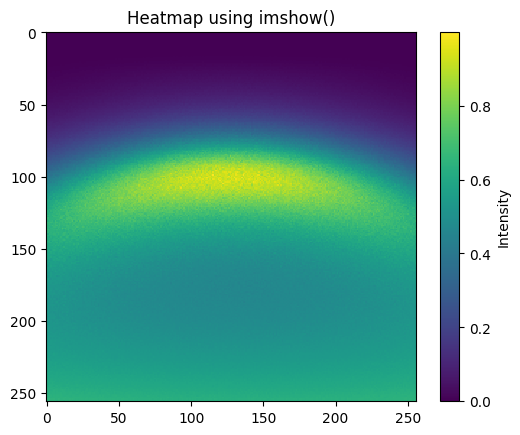

In [8]:
show_spectre(generate_spectre()).show()

## Create or load dataset

In [8]:
gen_data = CNNDataset(5000, device, load=True)

F:\Work\python\AI\diplom\data.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.heatmaps = torch.load("heatmaps.ts")
F:\Work\python\AI\diplom\data.py:22: FutureWarni

## Dataset split

In [9]:
train_data, val_data = random_split(gen_data, (0.8, 0.2))

In [10]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Model Architecture

In [11]:
model = nn.Sequential(
    nn.Conv2d(1, 8, (5, 5), padding=2),
    nn.ReLU(True),
    nn.MaxPool2d(2),
    nn.Conv2d(8, 16, (3, 3), padding=1),
    nn.ReLU(True),
    nn.MaxPool2d(4),
    nn.Conv2d(16, 32, (3, 3), padding=1),
    nn.ReLU(True),
    nn.MaxPool2d(4),
    nn.Flatten(),
    nn.Linear(32 * 8 * 8, 16 * 4 * 4),
    nn.ReLU(True),
    nn.Linear(16 * 4 * 4, 64),
    nn.ReLU(True),
    nn.Linear(64, 5)
).to(device)

## Loss function

In [34]:
class SSIMLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3):
        super().__init__()
        self.ssim = SSIM(data_range=1.0, kernel_size=5, sigma=0.5)
        self.mse = nn.MSELoss()
        self.alpha = alpha
        self.beta = beta

    def forward(self, x, y):
        ssim_loss = 1 - self.ssim(torch.stack([torch.tensor(generate_spectre_by_values(i)[0]) for i in x]),
                                  torch.stack([torch.tensor(generate_spectre_by_values(i)[0]) for i in y]))
        mse_loss = self.mse(x, y)
        return self.alpha * ssim_loss + self.beta * mse_loss
    

In [35]:
loss_classification = SSIMLoss()
opt_classification = optim.Adam(model.parameters(), lr=0.001)

### Loss function test

In [14]:
A, B = generate_spectre(), generate_spectre()

In [15]:
loss = SSIMLoss()(torch.tensor([A[1], B[1]]), torch.tensor([B[1], A[1]]))

print(f"A = {A[1]}")
print(f"B = {B[1]}")
print(f"loss = {loss}")

A = (13.961165126325243, 1.8362753866412076, 5.65896734335495, 0.5470639398641848, 7.015368268467497)
B = (7.325843165666232, 1.4809301309785559, 5.891695168939124, 0.17224707389019445, 9.630945132586925)
loss = 4.107942581176758


F:\Work\python\AI\.venv\Lib\site-packages\torchmetrics\utilities\prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


# Training model

In [36]:
train_loss = []
val_loss = []

EPOCH = 15

for epoch in range(EPOCH):
    model.train()

    running_training_loss = []
    true_answer = 0

    # console better UI
    train_loop = tqdm(train_loader, leave=False)

    # training loop
    for x, targets in train_loop:
        # data setting
        x = x.to(device)
        targets = targets.to(device)

        # getting prediction and loss
        pred = model(x)
        loss = loss_classification(pred, targets)

        # back propogation
        opt_classification.zero_grad()
        loss.backward()
        opt_classification.step()

        # running metrics
        running_training_loss.append(loss.item())
        mean_train_loss = sum(running_training_loss) / len(running_training_loss)

        train_loop.set_description(f"Epoch [{epoch + 1} / {EPOCH}], train_loss={mean_train_loss:.4f}")

    # epoch metrics
    train_loss.append(mean_train_loss)

    # validation loop
    model.eval()
    with torch.no_grad():
        running_val_loss = []
        true_answer = 0

        for x, targets in val_loader:
            x = x.to(device)
            targets = targets.to(device)

            pred = model(x)
            loss = loss_classification(pred, targets)

            running_val_loss.append(loss.item())
            mean_val_loss = sum(running_val_loss) / len(running_val_loss)

    val_loss.append(mean_val_loss)

    train_loop.set_description(
        f"Epoch [{epoch + 1} / {EPOCH}], train_loss={mean_train_loss:.4f}, val_loss={mean_val_loss:.4f}")

## Model training validation 

In [37]:
fig_1 = go.Figure()
fig_1.add_trace(go.Scatter(y=train_loss, name="train_loss", mode="lines"))
fig_1.add_trace(go.Scatter(y=val_loss, name="val_loss", mode="lines"))

text_to_display = f"Validation loss = {str(val_loss[-1])} Train loss = {str(train_loss[-1])} <br>"

In [38]:
test_data = generate_spectre()

In [39]:
print(torch.tensor(test_data[0], device=device, dtype=torch.float32).unsqueeze(0).shape)

torch.Size([1, 1, 256, 256])


In [40]:
res = []

with torch.no_grad():
    pred = model(torch.tensor(test_data[0], device=device, dtype=torch.float32).unsqueeze(0))
    target = torch.tensor(test_data[1], device=device, dtype=torch.float32).unsqueeze(0)
    res.append(pred)
    res.append(target)
    res.append(loss_classification(pred, target))

In [41]:
res_text = f"<br>pred = {res[0]}, target = {res[1]}, loss = {res[2]}"

fig_1.update_layout(
    annotations=[
        go.layout.Annotation(
            text=text_to_display + get_model_summary(model, input_size=(1, 256, 256)).replace('\n', '<br>') + res_text,
            xref="paper", yref="paper",
            x=0.5, y=-1.35,
            showarrow=False,
            font=dict(size=12)
        )
    ],
    margin=dict(b=600),
    height=1100
)
    
fig_1.show()

### Saving model

In [42]:
torch.save(model.state_dict(), 'model_weights.pth')

### Test sample

In [43]:
show_diff(test_data, generate_spectre_by_values(pred[0]))